# 

# Phân tích dữ liệu phim trên data wed Themoviedb

## 1. Chuẩn bị dữ liệu

Tải các thư viện cần thiết chuẩn bị cho bước phân tích và trực quan hóa dữ liệu.

In [1]:
# Thư viện để tạo SparkSession, điểm khởi đầu cho PySpark
from pyspark.sql import SparkSession
# Thư viện cung cấp các hàm xử lý dữ liệu cho DataFrame
from pyspark.sql import functions as F

# Thư viện đồ họa thống kê dựa trên matplotlib
import seaborn as sns
# Thư viện vẽ đồ thị và trực quan hóa dữ liệu
import matplotlib.pyplot as plt

# Thư viện để xử lý mảng và tính toán số học
import numpy as np

# Module tính toán ma trận tương quan cho dữ liệu trong Spark
from pyspark.ml.stat import Correlation
# Module chuyển đổi các cột dữ liệu thành định dạng vector
from pyspark.ml.feature import VectorAssembler
# Module xây dựng và huấn luyện mô hình hồi quy tuyến tính trong Spark
from pyspark.ml.regression import LinearRegression

Tạo SparkSession mang tên "_Data Analyst with Spark_", kết nối đến datawarehouse (datawarehouse.duckdb) thông qua trình điều khiển JDBC DuckDB.

In [2]:
# Đường dẫn đến trình điều khiển JDBC DuckDB (tệp JAR)
duck_db_jdbc = "/home/diin/HocKi_7/DE_project/duckdb_jdbc-1.1.3.jar"
# Tạo SparkSession
spark = SparkSession.builder \
    .appName("Data Analyst with Spark") \
    .config("spark.jars", duck_db_jdbc) \
    .getOrCreate()

# Đường dẫn của Datawarehouse
datawarehouse_path ='/home/diin/HocKi_7/DE_project/warehouse/datawarehouse.duckdb'

# Kết nối Spark với Datawarehouse
jdbc_url = f"jdbc:duckdb:{datawarehouse_path}"

25/01/17 19:04:26 WARN Utils: Your hostname, diin resolves to a loopback address: 127.0.1.1; using 192.168.1.8 instead (on interface wlo1)
25/01/17 19:04:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/01/17 19:04:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Đọc dữ liệu từ DuckDB
movie_df = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "movie") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .load()

# Hiển thị dữ liệu
movie_df.show()

+-------+--------------------+-----------------+------------+----------+----------+-------+---------------+------------+-------------+-----------+
|     id|               title|original_language|vote_average|vote_count|popularity|runtime|          genre|release_year|release_month|release_day|
+-------+--------------------+-----------------+------------+----------+----------+-------+---------------+------------+-------------+-----------+
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|         Action|        2024|            7|         31|
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|      Adventure|        2024|            7|         31|
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|       Thriller|        2024|            7|         31|
| 572802|Aquaman and the L...|               en|         6.7|      2845|    120.55|    124|         Action|        202

In [4]:
#Kiểm tra lấy ra từ datawarehouse
movie_df.show()

+-------+--------------------+-----------------+------------+----------+----------+-------+---------------+------------+-------------+-----------+
|     id|               title|original_language|vote_average|vote_count|popularity|runtime|          genre|release_year|release_month|release_day|
+-------+--------------------+-----------------+------------+----------+----------+-------+---------------+------------+-------------+-----------+
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|         Action|        2024|            7|         31|
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|      Adventure|        2024|            7|         31|
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|       Thriller|        2024|            7|         31|
| 572802|Aquaman and the L...|               en|         6.7|      2845|    120.55|    124|         Action|        202

In [5]:
# Chọn dữ liệu riêng biệt (distinct data)
distinct_movies_df = movie_df.select("id" \
                                    ,"title"\
                                    ,"original_language"\
                                    ,"vote_average"\
                                    ,"vote_count"\
                                    ,"popularity"\
                                    ,"runtime"\
                                    ,"release_year"\
                                    ,"release_month"\
                                    ,"release_day").distinct()
distinct_movies_df.show()

+------+--------------------+-----------------+------------+----------+----------+-------+------------+-------------+-----------+
|    id|               title|original_language|vote_average|vote_count|popularity|runtime|release_year|release_month|release_day|
+------+--------------------+-----------------+------------+----------+----------+-------+------------+-------------+-----------+
|449755|Christmas Inherit...|               en|         6.3|       825|     23.03|    105|        2017|           12|         15|
|818647|   Through My Window|               es|         7.4|      3127|    128.91|    112|        2022|            2|          4|
|  9320|        The Avengers|               en|         4.4|       705|     18.21|     89|        1998|            8|         13|
|921636|        The Out-Laws|               en|         6.0|       699|     19.79|     95|        2023|            7|          7|
|776305|               Belle|               ja|         7.7|       748|     20.05|    121|

# 2. Khám phá bộ dữ liệu nghiên cứu

## 2.1. Tổng quát dữ liệu

In [6]:
## Thông tin chi tiết bộ dữ liệu
print('=== THÔNG TIN BỘ DỮ LIỆU ===')
print('Số lượng phần tử trong bộ dữ liệu:', distinct_movies_df.count())
print('Kích thước bộ dữ liệu số cột:',len(distinct_movies_df.columns))
print('Cấu trúc schema của bộ dữ liệu:')
distinct_movies_df.printSchema()

=== THÔNG TIN BỘ DỮ LIỆU ===
Số lượng phần tử trong bộ dữ liệu: 9747
Kích thước bộ dữ liệu số cột: 10
Cấu trúc schema của bộ dữ liệu:
root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- vote_average: decimal(3,1) (nullable = true)
 |-- vote_count: long (nullable = true)
 |-- popularity: decimal(10,2) (nullable = true)
 |-- runtime: long (nullable = true)
 |-- release_year: long (nullable = true)
 |-- release_month: long (nullable = true)
 |-- release_day: long (nullable = true)



Kiểm tra nhiễu dữ liệu

/tmp/ipykernel_24586/2622496894.py:15: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, orient="h", palette="Set2", linewidth=2.5)


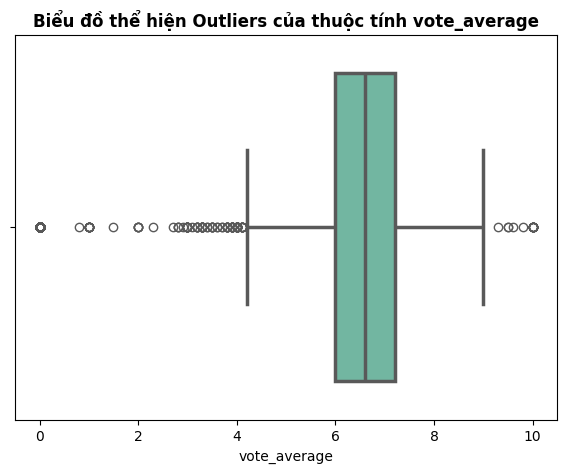

/tmp/ipykernel_24586/2622496894.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, orient="h", palette="Set2", linewidth=2.5)


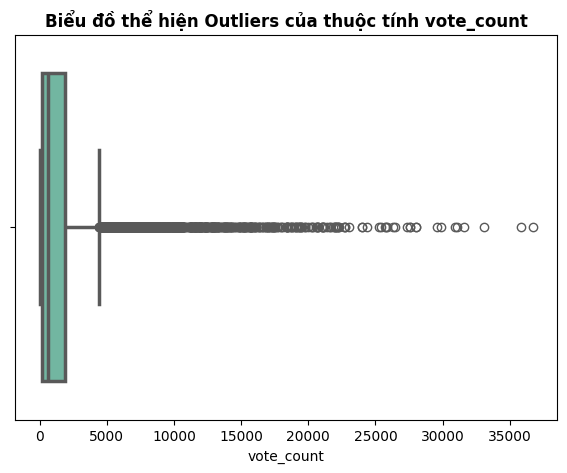

/tmp/ipykernel_24586/2622496894.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, orient="h", palette="Set2", linewidth=2.5)


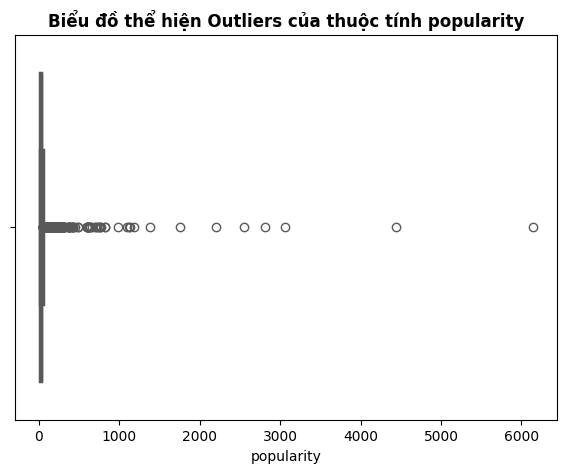

/tmp/ipykernel_24586/2622496894.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, orient="h", palette="Set2", linewidth=2.5)


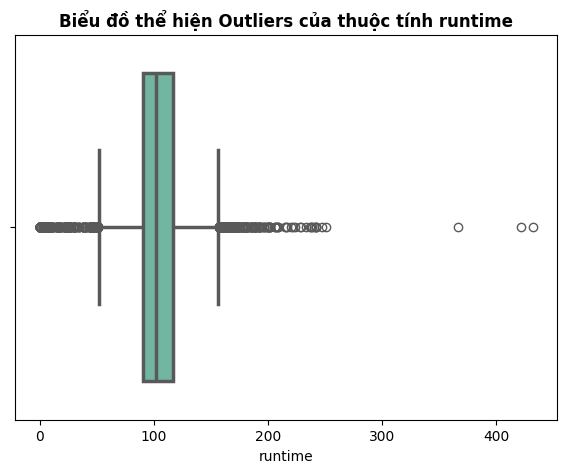

/tmp/ipykernel_24586/2622496894.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, orient="h", palette="Set2", linewidth=2.5)


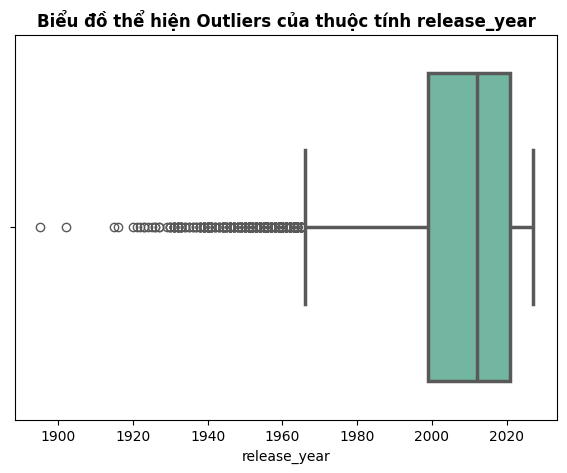

/tmp/ipykernel_24586/2622496894.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, orient="h", palette="Set2", linewidth=2.5)


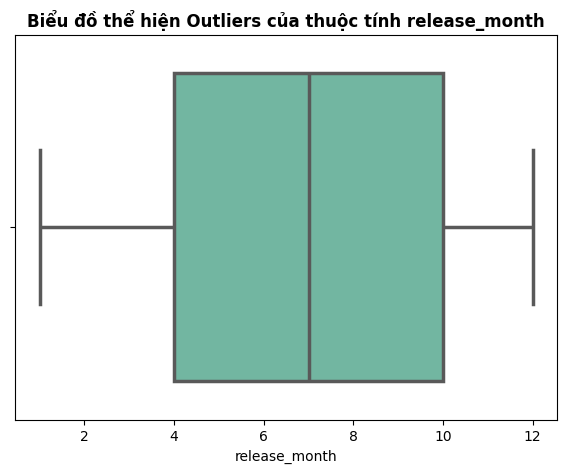

/tmp/ipykernel_24586/2622496894.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, orient="h", palette="Set2", linewidth=2.5)


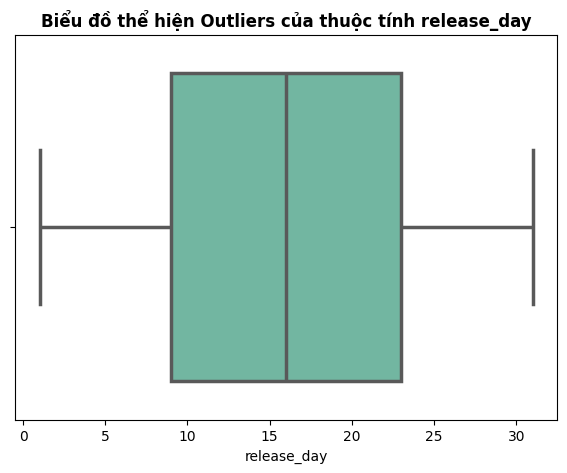

In [7]:
# Danh sách các cột cần kiểm tra Outliers
selected_columns = ["vote_average"\
                    ,"vote_count"\
                    ,"popularity"\
                    ,"runtime"\
                    ,"release_year"\
                    ,"release_month"\
                    ,"release_day"]
for column in selected_columns:
    # Trích xuất dữ liệu của từng cột thành danh sách
    data = distinct_movies_df.select(column).rdd.flatMap(lambda x: x).collect()
    
    # Vẽ boxplot cho cột hiện tại
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=data, orient="h", palette="Set2", linewidth=2.5)
    plt.title(f"Biểu đồ thể hiện Outliers của thuộc tính {column}", fontweight='bold')
    plt.xlabel(column)
    plt.show()


Xử lý dữ liệu gây nhiễu

/tmp/ipykernel_24586/1998702820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, orient="h", palette="Set2", linewidth=2.5)


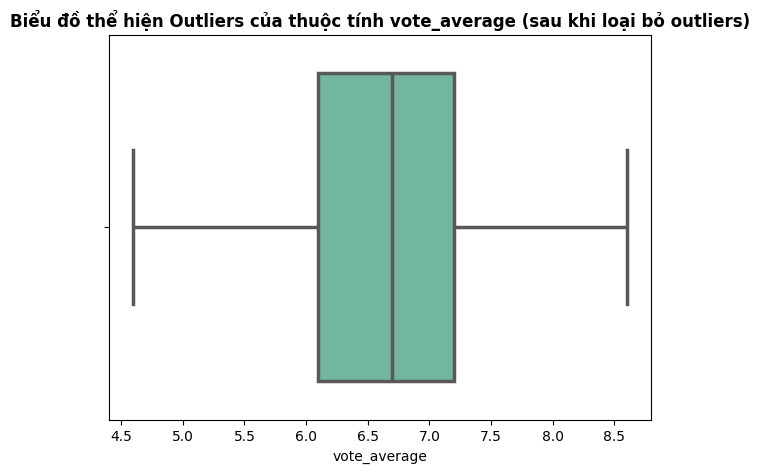

/tmp/ipykernel_24586/1998702820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, orient="h", palette="Set2", linewidth=2.5)


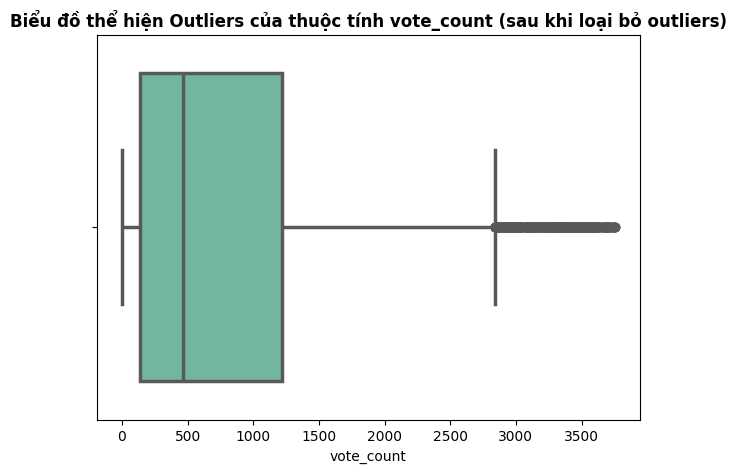

/tmp/ipykernel_24586/1998702820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, orient="h", palette="Set2", linewidth=2.5)


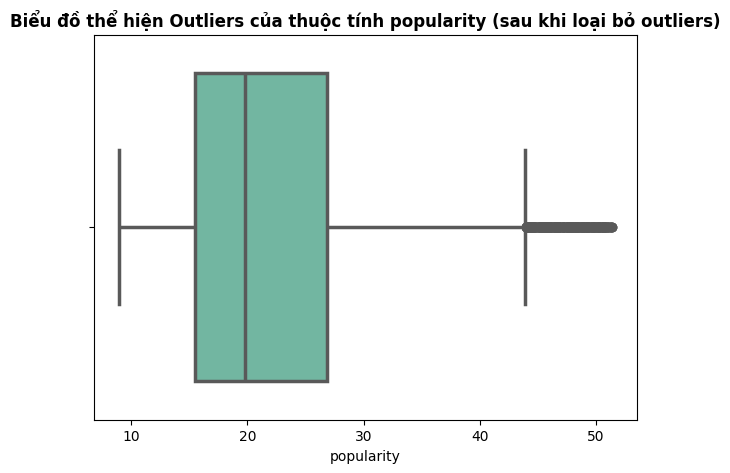

/tmp/ipykernel_24586/1998702820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, orient="h", palette="Set2", linewidth=2.5)


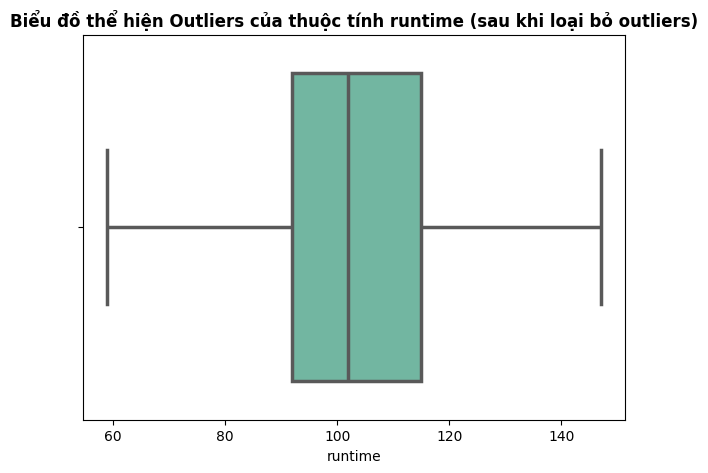

/tmp/ipykernel_24586/1998702820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, orient="h", palette="Set2", linewidth=2.5)


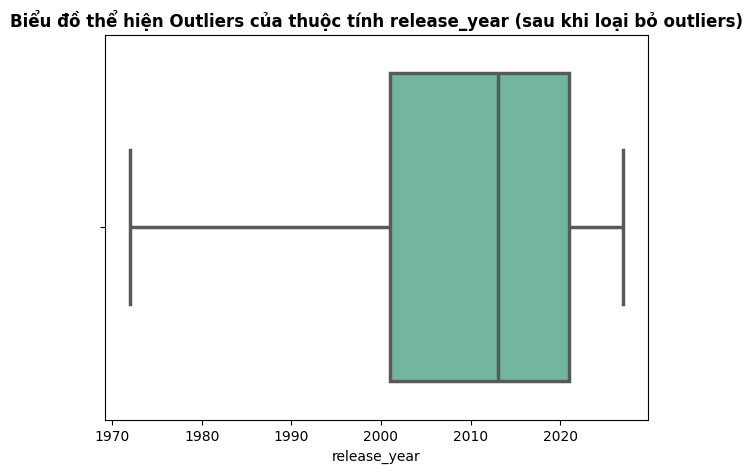

/tmp/ipykernel_24586/1998702820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, orient="h", palette="Set2", linewidth=2.5)


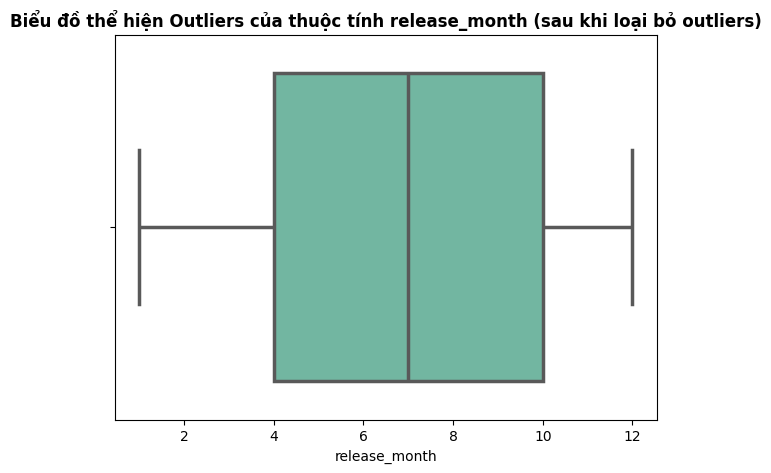

/tmp/ipykernel_24586/1998702820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, orient="h", palette="Set2", linewidth=2.5)


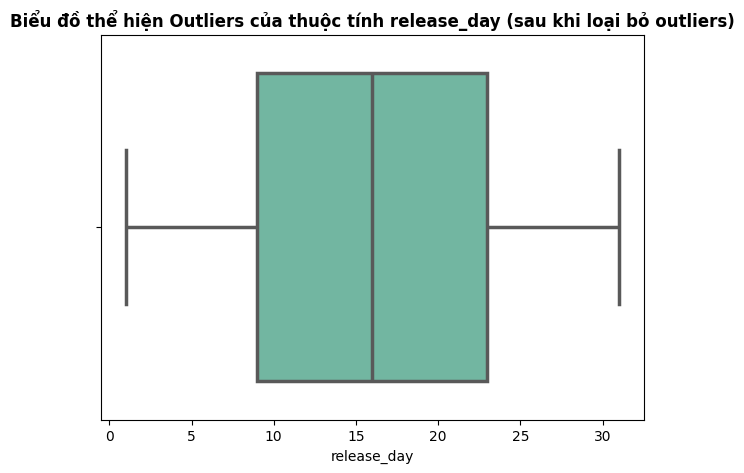

In [8]:
# Danh sách các cột cần kiểm tra Outliers
selected_columns = ["vote_average", "vote_count", "popularity", "runtime", "release_year", "release_month", "release_day"]
for column in selected_columns:
    # Tính toán Q1 (25th percentile) và Q3 (75th percentile) cho cột
    quantiles = distinct_movies_df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Lọc các giá trị ngoài giới hạn (outliers)
    movie_df_final = distinct_movies_df.filter((F.col(column) >= lower_bound) & (F.col(column) <= upper_bound))
    
    # Trích xuất dữ liệu sau khi loại bỏ outliers và chuyển thành danh sách
    filtered_data = movie_df_final.select(column).rdd.flatMap(lambda x: x).collect()

    # Vẽ boxplot cho cột sau khi loại bỏ outliers
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=filtered_data, orient="h", palette="Set2", linewidth=2.5)
    plt.title(f"Biểu đồ thể hiện Outliers của thuộc tính {column} (sau khi loại bỏ outliers)", fontweight='bold')
    plt.xlabel(column)
    plt.show()

## 2.2. Xử lý chi tiết

### 2.2.1. Original Language

In [9]:
# Thông tin của cột Original Language
movie_df_final.describe('original_language').show()

+-------+-----------------+
|summary|original_language|
+-------+-----------------+
|  count|             9747|
|   mean|             NULL|
| stddev|             NULL|
|    min|               ar|
|    max|               zu|
+-------+-----------------+



In [10]:
# Đếm số lần xuất hiện của từng ngôn ngữ
language_counts = movie_df_final.groupBy("original_language").count()
# Hiển thị kết quả
language_counts.show()

+-----------------+-----+
|original_language|count|
+-----------------+-----+
|               en| 7116|
|               vi|    3|
|               ro|    1|
|               ka|    1|
|               lv|    1|
|               pl|   28|
|               cn|  132|
|               sk|    1|
|               pt|   25|
|               tl|   59|
|               sh|    1|
|               ko|  339|
|               ms|    4|
|               uk|    3|
|               cs|    4|
|               mr|    1|
|               sr|    4|
|               tr|   18|
|               de|   87|
|               is|    3|
+-----------------+-----+
only showing top 20 rows



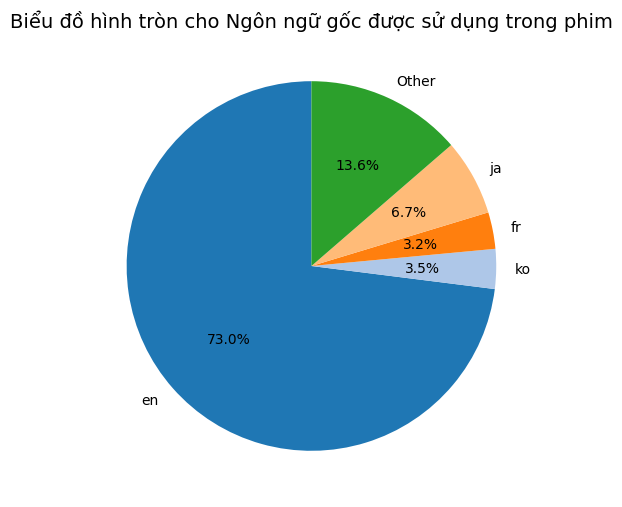

In [11]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột "original_language"
language_count = language_counts.collect()

# Chuyển kết quả thành các danh sách
labels = [row["original_language"] for row in language_count]
sizes = [row["count"] for row in language_count]

# Tính tổng số phim để tính tỷ lệ phần trăm
total_count = sum(sizes)

# Định nghĩa ngưỡng tỷ lệ phần trăm (< 3%)
threshold = 0.03

# Tạo danh sách lưu trữ nhãn và kích thước cho biểu đồ hình tròn
new_labels = []
new_sizes = []

# Nhóm các ngôn ngữ có tỷ lệ nhỏ vào "Other"
other_size = 0
for label, size in zip(labels, sizes):
    percentage = size / total_count
    if percentage < threshold:
        other_size += size
    else:
        new_labels.append(label)
        new_sizes.append(size)

# Nếu có ngôn ngữ ít phổ biến, thêm vào nhóm "Other"
if other_size > 0:
    new_labels.append("Other")
    new_sizes.append(other_size)

# Vẽ biểu đồ hình tròn
plt.figure(figsize=(8, 6))
plt.pie(
    new_sizes, 
    labels=new_labels, 
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab20.colors
)

plt.title('Biểu đồ hình tròn cho Ngôn ngữ gốc được sử dụng trong phim', fontsize=14)
plt.show()  # Hiển thị biểu đồ


Thông qua biểu đồ ta có thể thấy:       
    - Tiếng Anh (en) chiếm ưu thế rõ rệt, cho thấy sự phổ biến của nó trong nội dung hoặc dữ liệu được khảo sát.      
    - Nhóm "Other" cũng đáng kể (13.6%), có thể bao gồm nhiều ngôn ngữ ít phổ biến hơn.       
    - Các ngôn ngữ khác như tiếng Nhật (ja: 6.7%), tiếng Pháp (fr: 3.2%), và tiếng Hàn (ko: 3.5%) có tỷ lệ khá tương đồng nhưng kém hơn nhiều so với tiếng Anh.

### 2.2.1. Voting

In [12]:
# Thông tin của cột vote_average
movie_df_final.describe("vote_average").show()

+-------+------------------+
|summary|      vote_average|
+-------+------------------+
|  count|              9747|
|   mean|           6.47881|
| stddev|1.2018768707710754|
|    min|               0.0|
|    max|              10.0|
+-------+------------------+



In [13]:
# Thông tin của cột vote_average
movie_df_final.describe("vote_count").show()

+-------+-----------------+
|summary|       vote_count|
+-------+-----------------+
|  count|             9747|
|   mean|1782.151020826921|
| stddev|3198.683319239326|
|    min|                0|
|    max|            36702|
+-------+-----------------+



In [14]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột "vote_average"
vote_average_counts = movie_df_final.select("vote_average", "vote_count")
# Hiển thị kết quả
vote_average_counts.show()

+------------+----------+
|vote_average|vote_count|
+------------+----------+
|         6.3|       825|
|         7.4|      3127|
|         4.4|       705|
|         6.0|       699|
|         7.7|       748|
|         5.0|        13|
|         7.1|       330|
|         7.0|       205|
|         6.6|      1275|
|         7.4|      3599|
|         6.4|      1392|
|         7.4|       131|
|         7.3|     11616|
|         6.4|      1013|
|         6.5|       494|
|         7.2|       307|
|         7.3|       935|
|         0.0|         0|
|         6.4|       203|
|         6.0|       438|
+------------+----------+
only showing top 20 rows



In [15]:
# Nhóm các giá trị vào từng khoảng
data_with_group = vote_average_counts.withColumn("vote_average", (F.floor(vote_average_counts['vote_average'])))
# Nhóm theo cột "vote_average" và tính tổng số lượt đánh giá (sử dụng hàm sum)
grouped_data_vote_average = data_with_group.groupBy("vote_average").agg(F.count("vote_count").alias("vote_count")).orderBy("vote_average")
# Hiển thị kết quả
grouped_data_vote_average.show()

+------------+----------+
|vote_average|vote_count|
+------------+----------+
|           0|       148|
|           1|        10|
|           2|        10|
|           3|        53|
|           4|       306|
|           5|      1681|
|           6|      4112|
|           7|      3008|
|           8|       398|
|           9|        10|
|          10|        11|
+------------+----------+



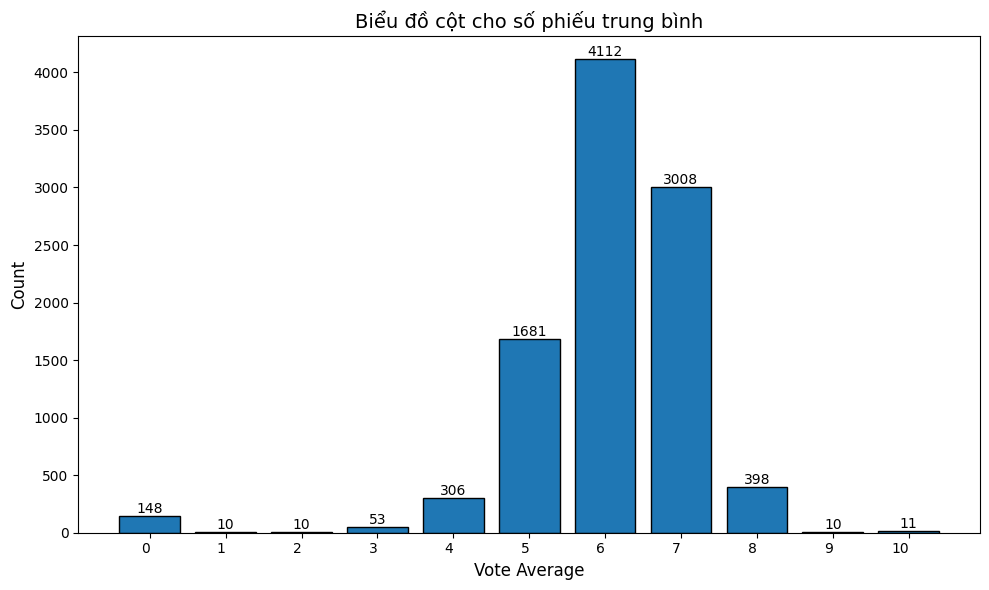

In [16]:
data_vote_average = grouped_data_vote_average.collect()
# Chuyển đổi kết quả thành danh sách
vote_average = [row["vote_average"] for row in data_vote_average]
vote_count = [row["vote_count"] for row in data_vote_average]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(vote_average, vote_count, edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Biểu đồ cột cho số phiếu trung bình', fontsize=14)
plt.xlabel('Vote Average', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Đặt nhãn trung hoành để hiển thị giá trị từ 0 đến 10
plt.xticks(range(11), ha='right')

# Thêm nhãn dữ liệu phía trên mỗi cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom', fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Dữ liệu nổi bật:        
- Vote Average = 6 (6.0 - 6.9): Đây là mức trung bình được đánh giá nhiều nhất, với 4112 phim.        
- Vote Average = 7 (7.0 - 7.9): Xếp thứ hai, với 3008 phim.       
- Vote Average = 5 (5.0 - 5.9): Có số lượng phim 1681, đứng thứ ba.     
        
Nhận xét:   
- Phần lớn người xem hoặc người đánh giá có xu hướng đánh giá các bộ phim ở mức trung bình, cụ thể là khoảng 5-7.     
- Rất ít phim đạt mức đánh giá xuất sắc (9-10), cho thấy sự khắt khe của người đánh giá.      
- Số lượng phim có mức đánh giá thấp (0-3) cũng rất ít, điều này có thể phản ánh rằng đa số phim đã đạt được một tiêu chuẩn tối thiểu.        

### 2.2.3. Genre

In [17]:
# Thông tin của cột Genre
movie_df.describe("genre").show()

+-------+-------+
|summary|  genre|
+-------+-------+
|  count|  25691|
|   mean|   NULL|
| stddev|   NULL|
|    min| Action|
|    max|Western|
+-------+-------+



In [18]:
# Đếm số lượng phim theo từng thể lọai phim (1 phim có thể có nhiều thể loại) 
occupation_counts = movie_df.groupBy('genre').count()
# Hiển thị kết quả
occupation_counts.show()

+---------------+-----+
|          genre|count|
+---------------+-----+
|          Crime| 1344|
|        Romance| 1599|
|       TV Movie|  191|
|       Thriller| 2547|
|      Adventure| 1809|
|          Drama| 3951|
|            War|  315|
|    Documentary|  141|
|         Family| 1254|
|        Fantasy| 1299|
|        History|  448|
|        Mystery|  827|
|      Animation| 1223|
|          Music|  241|
|Science Fiction| 1214|
|         Horror| 1468|
|        Western|  155|
|         Comedy| 2965|
|         Action| 2700|
+---------------+-----+



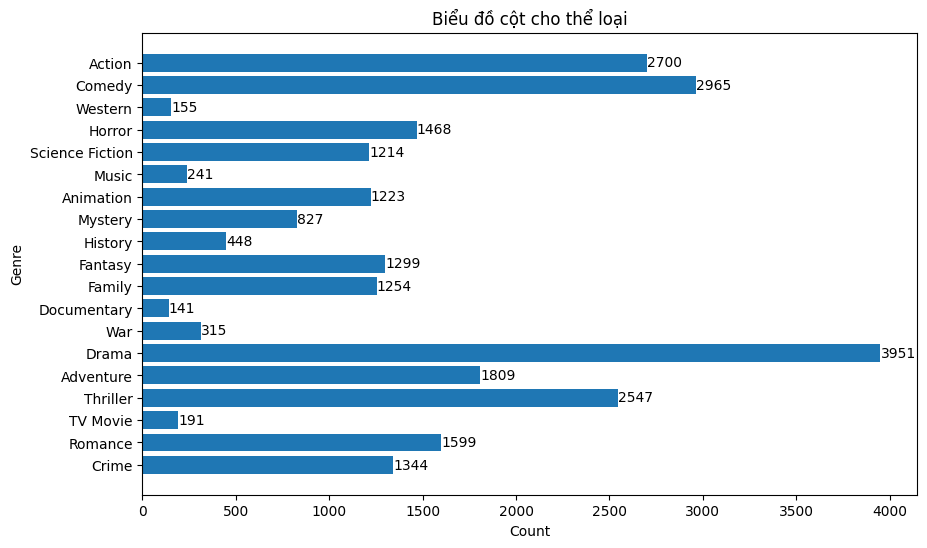

In [19]:
data_genre = occupation_counts.collect()

# Trích xuất dữ liệu vào danh sách để vẽ đồ thị
genres = [row['genre'] for row in data_genre]
counts = [row['count'] for row in data_genre]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.barh(genres, counts)

# Thêm nhãn số lượng vào đầu mỗi cột
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), 
             va='center', ha='left', fontsize=10)

plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Biểu đồ cột cho thể loại')

# Hiển thị kết quả
plt.show()


Nhận xét về biểu đồ:    
- Thể loại phổ biến nhất:
    - Drama (3951) là thể loại có số lượng phim cao nhất, chiếm ưu thế rõ rệt trong bảng xếp hạng. Điều này cho thấy sự phổ biến và nhu cầu cao đối với các bộ phim thuộc thể loại này.
    - Comedy (2965) và Action (2700) cũng nằm trong các thể loại có số lượng phim lớn, phản ánh xu hướng ưa chuộng các bộ phim hài và hành động.
    Thể loại ít phổ biến:
    - Western (155) và Documentary (141) là những thể loại có số lượng phim thấp nhất, cho thấy sự quan tâm và sản xuất ít đối với các thể loại này trong bộ sưu tập dữ liệu.
- Các thể loại trung bình:
    - Các thể loại như Horror (1468), Fantasy (1299), và Romance (1599) có số lượng phim trung bình, nằm giữa phổ biến và ít phổ biến.
- Xu hướng chung:
    - Các thể loại Drama, Comedy, và Action chiếm tỷ lệ lớn trong dữ liệu, cho thấy đây là những thể loại được yêu thích và sản xuất nhiều nhất.
    - Ngược lại, thể loại Western và Documentary ít xuất hiện hơn, có thể là vì chúng có đối tượng khán giả hẹp hoặc ít được sản xuất trong giai đoạn gần đây.

### 2.2.4. Năm phát hành (từ năm 2000 đến năm 2024)

In [20]:
# Lọc theo các năm từ 2000 đến 2024 và sắp xếp theo 'release_year'
year_count = movie_df_final.groupBy("release_year").count() \
    .filter((movie_df_final['release_year'] >= 2000) & (movie_df_final['release_year'] < 2025)) \
    .orderBy("release_year")

# Hiển thị DataFrame kết quả với số lượng phim cho mỗi năm
year_count.show()


+------------+-----+
|release_year|count|
+------------+-----+
|        2000|  145|
|        2001|  148|
|        2002|  153|
|        2003|  166|
|        2004|  190|
|        2005|  191|
|        2006|  206|
|        2007|  217|
|        2008|  195|
|        2009|  221|
|        2010|  225|
|        2011|  235|
|        2012|  222|
|        2013|  224|
|        2014|  256|
|        2015|  254|
|        2016|  267|
|        2017|  314|
|        2018|  314|
|        2019|  324|
+------------+-----+
only showing top 20 rows



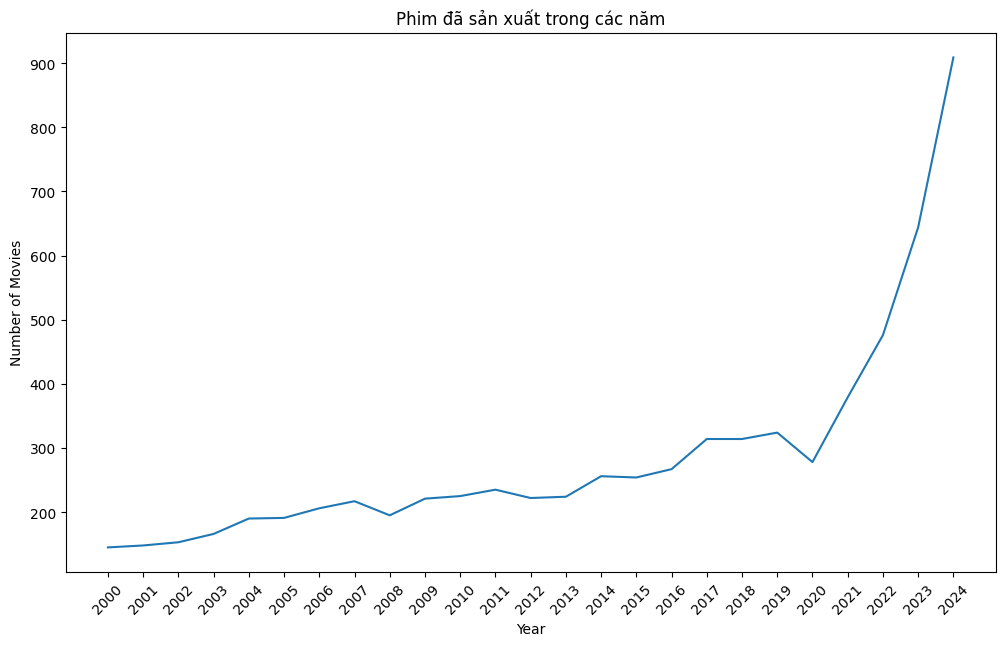

In [21]:
movie_in_year = year_count.collect()

# Trích xuất dữ liệu vào các danh sách riêng
years = [row['release_year'] for row in movie_in_year]
movie_counts = [row['count'] for row in movie_in_year]

plt.figure(figsize=(12, 7))
plt.plot(years, movie_counts, linestyle='-')

# Thêm nhãn và tiêu đề
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Phim đã sản xuất trong các năm')

# Điều chỉnh trục x để đảm bảo văn bản vừa vặn
plt.xticks(years, rotation=45)
plt.show()

Xu hướng chung:     
- Số lượng phim sản xuất hàng năm tăng mạnh, đặc biệt từ sau năm 2019, thể hiện sự phát triển vượt bậc trong ngành công nghiệp sản xuất phim.

Giai đoạn tăng trưởng chậm:
- Trong khoảng thời gian từ năm 2000 đến 2010, số lượng phim sản xuất mỗi năm tăng chậm, chỉ dao động nhẹ quanh mức 200–300 phim.

Giai đoạn tăng trưởng ổn định:
- Từ năm 2010 đến 2018, số lượng phim sản xuất tăng đều, nhưng không có sự đột phá lớn.

Tăng trưởng vượt bậc:
- Từ năm 2019 trở đi, số lượng phim tăng mạnh, đạt gần 1000 phim vào năm 2024. Điều này có thể do sự gia tăng nhu cầu giải trí, phát triển của các nền tảng phát trực tuyến, hoặc sự phát triển của công nghệ làm phim.

Tác động từ đại dịch COVID-19:
- Giai đoạn 2020 có thể bị ảnh hưởng bởi đại dịch, dẫn đến số lượng phim sản xuất thấp hơn so với xu hướng tăng trưởng trước đó. Tuy nhiên, sau đó số lượng phim đã phục hồi và tăng mạnh.

### 2.2.5. Tháng phát hành

In [22]:
# Đếm bộ phim được sản xuất trong các tháng và sắp xếp từ tháng 1 đến tháng 12
month_count = movie_df_final.groupBy("release_month").count().orderBy("release_month")
# Hiển thị kết quả
month_count.show()

+-------------+-----+
|release_month|count|
+-------------+-----+
|            1|  560|
|            2|  708|
|            3|  788|
|            4|  683|
|            5|  659|
|            6|  765|
|            7|  779|
|            8|  870|
|            9|  965|
|           10| 1023|
|           11|  863|
|           12| 1084|
+-------------+-----+



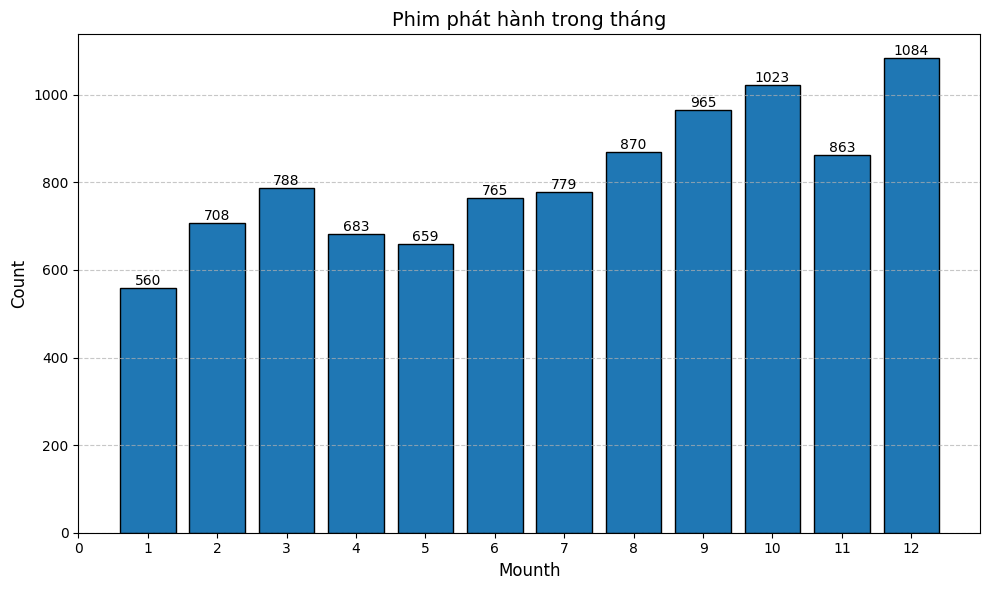

In [23]:
movie_on_month = month_count.collect()
# Chuyển đổi kết quả thành danh sách
month = [row["release_month"] for row in movie_on_month]
count = [row["count"] for row in movie_on_month]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(month, count, edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Phim phát hành trong tháng', fontsize=14)
plt.xlabel('Mounth', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Đặt nhãn trung hoành để hiển thị giá trị từ 0 đến 12
plt.xticks(range(13), ha='center')

# Thêm đường lưới để rõ ràng hơn
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn dữ liệu ở trên mỗi cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom', fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Xu hướng phát hành phim theo tháng:
- Số lượng phim phát hành tăng dần từ tháng 1 đến tháng 3, đạt mức cao vào tháng 3 (788 phim).
- Tháng 4 và tháng 5 có số lượng phim phát hành giảm nhẹ, nhưng vẫn giữ mức ổn định (683 và 659 phim).
- Từ tháng 6 đến tháng 10, số lượng phim tăng liên tục, đặc biệt cao vào tháng 10 với 1023 phim – đây là tháng có số lượng phim phát hành nhiều nhất.
- Từ tháng 11 đến tháng 12, số lượng phim giảm nhẹ so với tháng 10, nhưng vẫn giữ ở mức cao (1084 phim vào tháng 12).

Tháng cao điểm:
- Tháng 9, 10 là tháng cao điểm với số lượng phim phát hành cao nhất, có thể do đây là thời gian thuận lợi để ra mắt phim, chuẩn bị cho mùa lễ hội cuối năm.
- Tháng 12 cũng có số lượng phim phát hành cao, có thể do nhu cầu giải trí dịp cuối năm.

Tháng thấp điểm:
- Tháng 1 có số lượng phim phát hành thấp nhất (560 phim), có thể do đây là thời gian nghỉ lễ đầu năm và các nhà sản xuất chờ đợi thời điểm tốt hơn.

### 2.2.5. Ngày phát hành

In [24]:
# Đếm bộ phim được sản xuất trong các ngày và sắp xếp tăng dần
day_count = movie_df_final.groupBy("release_day").count().orderBy("release_day")
# Hiển thị kết quả
day_count.show()

+-----------+-----+
|release_day|count|
+-----------+-----+
|          1|  379|
|          2|  279|
|          3|  286|
|          4|  274|
|          5|  289|
|          6|  296|
|          7|  313|
|          8|  285|
|          9|  321|
|         10|  314|
|         11|  333|
|         12|  367|
|         13|  351|
|         14|  360|
|         15|  357|
|         16|  332|
|         17|  336|
|         18|  331|
|         19|  324|
|         20|  335|
+-----------+-----+
only showing top 20 rows



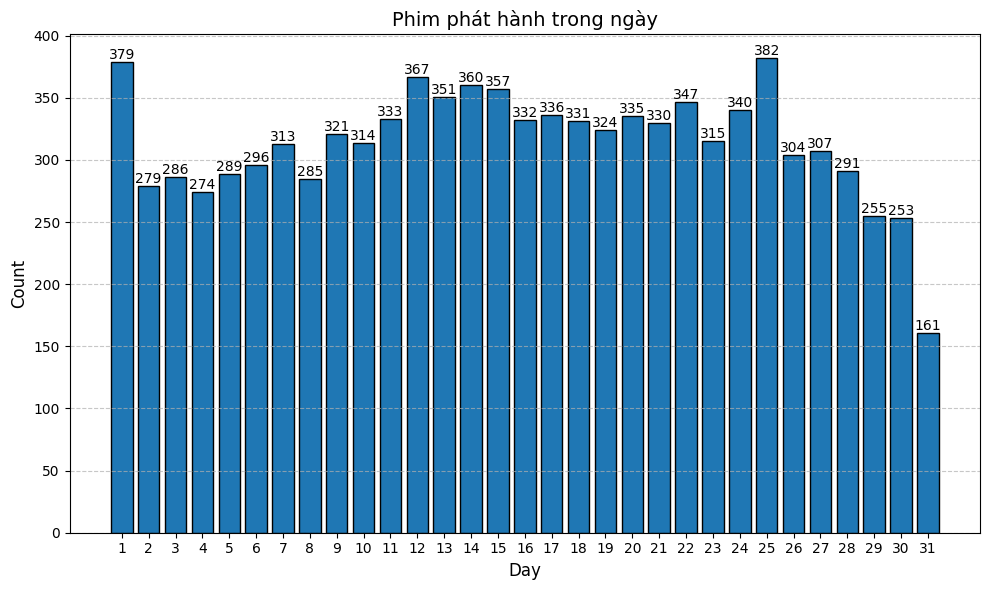

In [25]:
movie_on_day = day_count.collect()
# Chuyển đổi kết quả thành danh sách
day = [row["release_day"] for row in movie_on_day]
count = [row["count"] for row in movie_on_day]

# Tạo biểu đồ thanh
plt.figure(figsize=(10, 6))
bars = plt.bar(day, count, edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Phim phát hành trong ngày', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Đặt dấu x để hiển thị giá trị từ 0 đến 31
plt.xticks(range(1,32), ha='center')

# Thêm đường lưới để rõ ràng hơn
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn dữ liệu ở trên mỗi thanh
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom', fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Xu hướng phát hành phim theo ngày:
- Ngày 25 có số lượng phim phát hành rất cao (382 phim), vượt trội so với các ngày còn lại, cho thấy đây có thể là thời điểm được các nhà phát hành ưu tiên công chiếu phim mới.
- Từ ngày 1 đến ngày 15, số lượng phim phát hành dao động trong khoảng từ 279 đến 367 phim, thể hiện sự ổn định với một mức độ phát hành đều đặn.
- Giai đoạn từ ngày 16 đến ngày 25, số lượng phim phát hành có xu hướng tăng nhẹ, dao động từ 305 đến 373 phim. Đặc biệt, ngày 24 là một trong những ngày cao điểm với 373 phim được phát hành.
- Từ ngày 27 trở đi, số lượng phim phát hành giảm mạnh, đáng chú ý là ngày 31 có số lượng thấp nhất trong tháng, chỉ 161 phim.

Ngày cao điểm:
- Ngày 1 và ngày 26 là hai ngày có số lượng phim phát hành nhiều nhất trong tháng, lần lượt đạt 379 và 382 phim. Điều này có thể liên quan đến các chiến lược marketing hoặc sự kiện đặc biệt, ví dụ như khởi đầu tháng mới hoặc ngày cuối tuần thuận lợi.

Ngày thấp điểm:
- Ngày 31 có số lượng phim phát hành thấp nhất (161 phim), có thể do đây là ngày cuối tháng, thường không được các hãng phim ưu tiên để công chiếu phim mới.

## 2.3. Phân tích tương quan giữa các cột

In [26]:
# Danh sách các cột
vector_col = ["vote_average","vote_count","popularity","runtime","release_year","release_month","release_day"]
# Tạo Vector từ các cột
vector_assembler = VectorAssembler(inputCols=vector_col, outputCol="features")
numeric_df = vector_assembler.transform(movie_df_final)

# Tính toán ma trận tương quan
correlation_matrix = Correlation.corr(numeric_df, "features", "pearson").head()[0]
print(correlation_matrix)

DenseMatrix([[ 1.        ,  0.25173594,  0.04497829,  0.32483305, -0.15274597,
               0.01807159, -0.018081  ],
             [ 0.25173594,  1.        ,  0.10078937,  0.25527526, -0.00701014,
               0.01807525,  0.00319303],
             [ 0.04497829,  0.10078937,  1.        ,  0.0308342 ,  0.08921194,
               0.05300899,  0.01511507],
             [ 0.32483305,  0.25527526,  0.0308342 ,  1.        , -0.07968514,
               0.04606075,  0.01803791],
             [-0.15274597, -0.00701014,  0.08921194, -0.07968514,  1.        ,
               0.01240349, -0.01034027],
             [ 0.01807159,  0.01807525,  0.05300899,  0.04606075,  0.01240349,
               1.        , -0.00696639],
             [-0.018081  ,  0.00319303,  0.01511507,  0.01803791, -0.01034027,
              -0.00696639,  1.        ]])


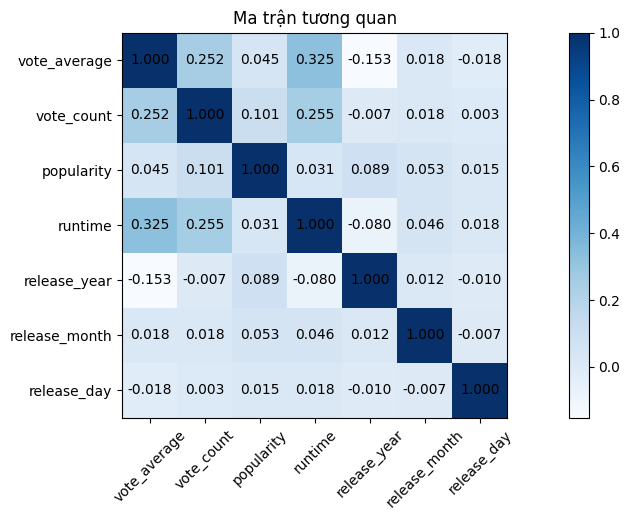

In [27]:
# Trích xuất dữ liệu từ DenseMatrix
correlation_matrix_array = correlation_matrix.toArray()

# Đặt kích thước của bản đồ nhiệt
plt.figure(figsize=(16, 5))

# Vẽ bản đồ nhiệt bằng matplotlib
plt.imshow(correlation_matrix_array, cmap='Blues')
plt.colorbar()

# Thêm nhãn vào các trục
plt.xticks(ticks=np.arange(len(vector_col)), labels=vector_col, rotation=45)
plt.yticks(ticks=np.arange(len(vector_col)), labels=vector_col)

# Thêm chú thích vào từng ô
for i in range(len(vector_col)):
    for j in range(len(vector_col)):
        plt.text(j, i, f'{correlation_matrix_array[i, j]:.3f}', 
                 ha='center', va='center', color='black')

plt.title("Ma trận tương quan")
plt.show()


Các biến với tương quan mạnh hơn:
- vote_average và runtime: Tương quan dương nhẹ (0.325). Điều này cho thấy thời lượng phim có một ảnh hưởng nhỏ nhưng đáng kể đến điểm đánh giá trung bình của phim.
- vote_count và runtime: Tương quan nhẹ (0.255). Số lượng bình chọn có mối liên hệ tích cực với thời lượng phim.

Các biến với tương quan yếu:
- vote_average và vote_count: Tương quan dương nhẹ (0.252). Các phim có nhiều lượt bình chọn thường có điểm trung bình cao hơn, nhưng mối quan hệ này không thực sự mạnh.
- release_year và popularity: Tương quan dương yếu (0.089). Các phim phát hành gần đây có xu hướng phổ biến hơn, nhưng ảnh hưởng này không đáng kể.

Các biến gần như không có tương quan:
- release_month, release_day và hầu hết các biến khác đều có hệ số tương quan gần 0. Điều này chỉ ra rằng tháng hoặc ngày phát hành không ảnh hưởng đáng kể đến các yếu tố như điểm đánh giá, số lượt bình chọn hay mức độ phổ biến.

Tương quan âm:
- release_year và vote_average: Tương quan âm nhẹ (-0.153). Phim phát hành gần đây có xu hướng nhận điểm đánh giá thấp hơn một chút.
- release_year và runtime: Tương quan âm nhẹ (-0.080). Các phim phát hành trong những năm gần đây có xu hướng ngắn hơn so với các phim cũ hơn.

## 2.4. Mô hình hồi quy OLS

In [28]:
# VectorAssembler để kết hợp 'vote_count' và 'vote_average' thành một vector đặc trưng
vector_assembler = VectorAssembler(inputCols=["vote_count"], outputCol="features")
assembled_df = vector_assembler.transform(movie_df_final)

# Hiển thị dataframe đã được kết hợp với features và biến mục tiêu
assembled_df.select("vote_count", "vote_average", "features").show()


+----------+------------+---------+
|vote_count|vote_average| features|
+----------+------------+---------+
|       825|         6.3|  [825.0]|
|      3127|         7.4| [3127.0]|
|       705|         4.4|  [705.0]|
|       699|         6.0|  [699.0]|
|       748|         7.7|  [748.0]|
|        13|         5.0|   [13.0]|
|       330|         7.1|  [330.0]|
|       205|         7.0|  [205.0]|
|      1275|         6.6| [1275.0]|
|      3599|         7.4| [3599.0]|
|      1392|         6.4| [1392.0]|
|       131|         7.4|  [131.0]|
|     11616|         7.3|[11616.0]|
|      1013|         6.4| [1013.0]|
|       494|         6.5|  [494.0]|
|       307|         7.2|  [307.0]|
|       935|         7.3|  [935.0]|
|         0|         0.0|    [0.0]|
|       203|         6.4|  [203.0]|
|       438|         6.0|  [438.0]|
+----------+------------+---------+
only showing top 20 rows



25/01/17 19:05:03 WARN Instrumentation: [e613d287] regParam is zero, which might cause numerical instability and overfitting.


Hệ số (Coefficients): [9.458754508321758e-05]
Hệ số chặn (Intercept): 6.310244704021911
R-squared: 0.0633709830007867
RMSE: 1.1631119082525259


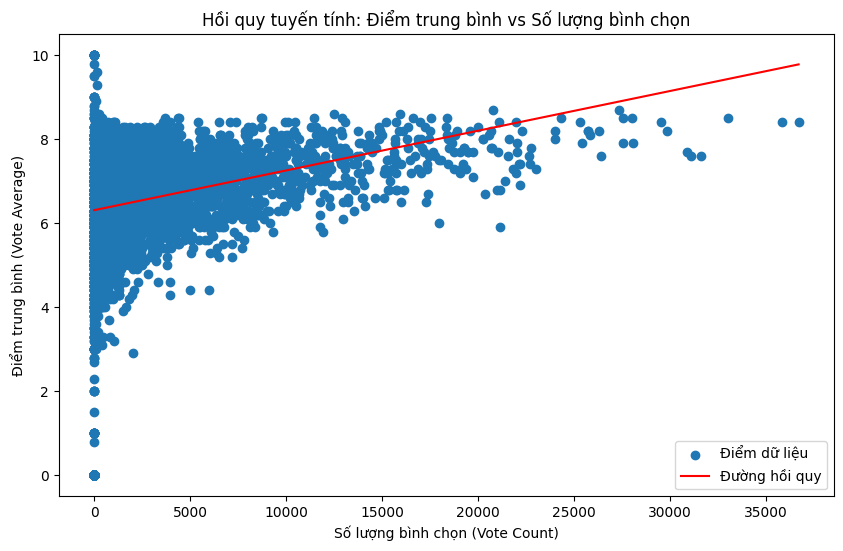

In [29]:
# Huấn luyện mô hình hồi quy tuyến tính
lr = LinearRegression(featuresCol="features", labelCol="vote_average")
lr_model = lr.fit(assembled_df)  # Huấn luyện mô hình với dữ liệu đã được kết hợp

# In ra tóm tắt mô hình
summary = lr_model.summary
print("Hệ số (Coefficients):", lr_model.coefficients)
print("Hệ số chặn (Intercept):", lr_model.intercept)
print("R-squared:", summary.r2)
print("RMSE:", summary.rootMeanSquaredError)

# Dự đoán từ mô hình hồi quy tuyến tính
predictions = lr_model.transform(assembled_df)

# Sắp xếp dữ liệu theo "features" để vẽ đường hồi quy chính xác
predictions = predictions.orderBy("features")

# Trích xuất các cột cần thiết để vẽ biểu đồ
vote_count = [row["features"][0] for row in predictions.select("features").collect()]
vote_average = [row["vote_average"] for row in predictions.select("vote_average").collect()]
predictions_values = [row["prediction"] for row in predictions.select("prediction").collect()]

# Vẽ biểu đồ với các điểm dữ liệu và đường hồi quy
plt.figure(figsize=(10, 6))
plt.scatter(vote_count, vote_average, label="Điểm dữ liệu")
plt.plot(vote_count, predictions_values, color="red", label="Đường hồi quy")
plt.xlabel("Số lượng bình chọn (Vote Count)")
plt.ylabel("Điểm trung bình (Vote Average)")
plt.title("Hồi quy tuyến tính: Điểm trung bình vs Số lượng bình chọn")
plt.legend()
plt.show()


Thông số hồi quy:
- Hệ số (Coefficient): 9.458754508321758e-05
    : Hệ số này cho thấy rằng với mỗi lượt bình chọn tăng thêm, điểm trung bình của phim tăng rất nhẹ, cụ thể là khoảng 0.0000946 điểm.

- Hệ số chặn (Intercept): 6.310244704021911
    : Điểm trung bình dự đoán khi số lượng bình chọn bằng 0 là khoảng 6.31.

- R-squared (Hệ số xác định): 0.063
    : Điều này chỉ ra rằng chỉ 6.3% sự biến đổi trong điểm trung bình (Vote Average) được giải thích bởi số lượng bình chọn (Vote Count). Mối quan hệ này khá yếu.

- RMSE (Root Mean Square Error): 1.163
    : Sai số trung bình bình phương gốc (RMSE) cho thấy mức độ chênh lệch giữa giá trị dự đoán và giá trị thực tế là khoảng 1.16 điểm.

Đánh giá đồ thị:

- Xu hướng tổng quan: Đường hồi quy tuyến tính (màu đỏ) có độ dốc rất nhỏ, thể hiện rằng mặc dù có mối quan hệ dương giữa số lượng bình chọn và điểm trung bình, mối quan hệ này không rõ ràng hoặc mạnh mẽ.
- Phân bố dữ liệu:
    - Phần lớn các điểm dữ liệu tập trung ở vùng có số lượng bình chọn thấp (gần trục tung), cho thấy đa số phim có ít lượt bình chọn.
    - Có một số phim với số lượng bình chọn rất cao, nhưng không nhất thiết luôn có điểm trung bình cao.

Kết luận:

- Mối quan hệ yếu: Mặc dù số lượng bình chọn có ảnh hưởng đến điểm trung bình, ảnh hưởng này là rất nhỏ và không đáng kể về mặt thực tiễn.
- Phân bố không đều: Đa số phim có số lượng bình chọn thấp, và chỉ một số ít phim có lượt bình chọn cao hơn.
- Hạn chế của mô hình: Với giá trị R-squared thấp (0.063), mô hình hồi quy tuyến tính này không phải là một công cụ tốt để dự đoán điểm trung bình dựa trên số lượng bình chọn.

In [30]:
# Dừng Spark session
spark.stop()